In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, Matern, RationalQuadratic, ExpSineSquared
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import random
import pickle
import json
import joblib

In [7]:
df = pd.read_csv('8-11-23_cleaned_enthalpy_data.csv')

In [40]:
# now using hyper parameters found in the diagnosing notebook as well as the optimized features
params = {'alpha': 0.01, 'kernel': 13.9**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=17.6)}
fp_columns = ['Mmfp_MQNs34', 'Mmfp_MQNs33', 'Mmfp_MQNs36', 'bfp_197', 'efp_fam_single', 'afp_C3_C4_H1', 'Mmfp_MQNs35',
              '1/length', 'afp_C4_C4_C4', 'afp_C3_C4_C4', 'one_hot_fp_dft', 'one_hot_fp_expt', 'Mmfp_MQNs38', 
              'afp_C3_C4_C3', 'cfp_val_e_diff', 'afp_C3_C3_C4', 'Mmfp_MQNs39', 'Mmfp_MQNs37', 'efp_fam_acrylate', 
              'afp_C4_C3_O2', 'bfp_376', 'efp_side_chain_abs', 'afp_C4_C4_O2', 'bfp_249', 'bfp_282', 'efp_3v_main', 
              'afp_C4_S2_C4', 'cfp_rop_ring_size', 'afp_H1_C4_S2', 'efp_4v_side', 'afp_C4_C4_S2', 'bfp_375', 
              'efp_fam_polyamides', 'efp_fam_carbonateester', 'mfp_MQNs34', 'bfp_285', 'Mmfp_MQNs32', 'mfp_MQNs26', 
              'mfp_MQNs14', 'afp_C4_C3_S2', 'efp_4v_main', 'bfp_363', 'Mafp_N3', 'bfp_315', 'Mafp_S1', 'Mmfp_Chi0n', 
              'bfp_208', 'Mmfp_MQNs29', 'Mafp_H1', 'Mmfp_Chi1n']

In [15]:
# now getting exp and dft ids and exp IDs that have dft data and those that don't
exp_ids = set(df[df['source']=='expt']['ID'].tolist())
dft_ids = set(df[df['source']=='dft']['ID'].tolist())
exp_ids_with_dft = exp_ids.intersection(dft_ids)
exp_ids_without_dft = exp_ids-dft_ids
print(len(exp_ids), len(exp_ids_with_dft), len(exp_ids_without_dft))

109 68 41


In [16]:
# randomly sampling 5 ids with dft and 5 ids without dft
test_ids = set(random.sample(exp_ids_with_dft, 5)).union(set(random.sample(exp_ids_without_dft, 5)))
print(len(test_ids))

10


/var/folders/kv/jb_0lzrs1rn1t7k838wy_wgc0000gn/T/ipykernel_16417/3496687262.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  test_ids = set(random.sample(exp_ids_with_dft, 5)).union(set(random.sample(exp_ids_without_dft, 5)))


In [17]:
test_df = df[(df['ID'].isin(test_ids))&(df['source']=='expt')]
train_df = df[~((df['ID'].isin(test_ids))&(df['source']=='expt'))]
print(test_df.shape, train_df.shape)

(10, 260) (449, 260)


In [18]:
x_test = test_df[fp_columns].to_numpy()
y_test = test_df['roe_kj/mol'].to_numpy()
x_train = train_df[fp_columns].to_numpy()
y_train = train_df['roe_kj/mol'].to_numpy()

model = GaussianProcessRegressor(**params)
model.fit(x_train,y_train)
test_predictions, test_sigmas = model.predict(x_test, return_std=True)
train_predictions, train_sigmas = model.predict(x_train, return_std=True)

rmse_train = mean_squared_error(y_train, train_predictions, squared=False)
rmse_test = mean_squared_error(y_test, test_predictions, squared=False)
print(rmse_train, rmse_test)

2.9411716191387423 6.154014172548295


In [19]:
def parity_plot(y_train, predictions_train, sigmas_train, y_test, predictions_test, sigmas_test):
    
    plt.figure(figsize=(8, 6), dpi=80)
    # truth on the x, prediction on the y
    min_x = np.concatenate([y_train, y_test]).min()
    max_x = np.concatenate([y_train, y_test]).max()
    min_y = np.concatenate([predictions_train, predictions_test]).min()
    max_y = np.concatenate([predictions_train, predictions_test]).max()
    bounds = (min(min_x - 2, min_y  - 2), max(max_x + 2, max_y + 2))

    ax = plt.gca()
    ax.set_xlim(bounds)
    ax.set_ylim(bounds)

    # ax.set_aspect("equal", adjustable = "box")
    plots_ = list()
    
    #train_data
    ax.errorbar(y_train, predictions_train, 
                              yerr=sigmas_train, c='grey', zorder=4, ecolor='lightgrey', fmt='o', label='Train')
    #test_data
    ax.errorbar(y_test, predictions_test, 
                              yerr=sigmas_test, c='blue', zorder=4, ecolor='lightblue', fmt='o', label='Test')
    # plots_.append(plot_)

    ax.plot([0,1], [0,1], "k--", c='r', lw = 2, transform = ax.transAxes)

    # labeling axes
    # plt.title(title, fontsize=15, weight='bold')
    # plt.xlabel('Actual Enthalpy (KJ/mol)', fontsize=12, weight='bold')
    # plt.ylabel('Predicted Enthalpy (KJ/mol)', fontsize=12, weight='bold')

    ## CALCULATE STATISTICS
    rmse = mean_squared_error(y_test, predictions_test, squared=False)
    mae = mean_absolute_error(y_test, predictions_test)
    r2 = r2_score(y_test, predictions_test)
    # text = f" Test RMSE = {rmse:0.1f} kJ/mol\n Test MAE = {mae:0.1f} kJ/mol\n Test $R^{2}$ = {r2:0.2f}"
    text = f" Test RMSE = {rmse:0.1f} kJ/mol\n Test MAE = {mae:0.1f} kJ/mol"
    # ax.gca().text(0.05, 0.95, text_case_1,transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.02, 0.92, text,transform=ax.transAxes, fontsize=16, verticalalignment='top',) # weight="bold")
    plt.legend(loc='center right')
    plt.rc('legend', fontsize=16)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.xaxis.set_tick_params(labelsize=15)
    plt.xlabel('$\Delta H^{\mathrm{ROP}}_{\mathrm{expt}}$ (kJ/mol)', fontsize=16)
    plt.ylabel('$\Delta H^{\mathrm{ROP}}_{\mathrm{ML}}$ (kJ/mol)', fontsize=16)
    return ax

/var/folders/kv/jb_0lzrs1rn1t7k838wy_wgc0000gn/T/ipykernel_16417/2275172582.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0,1], [0,1], "k--", c='r', lw = 2, transform = ax.transAxes)


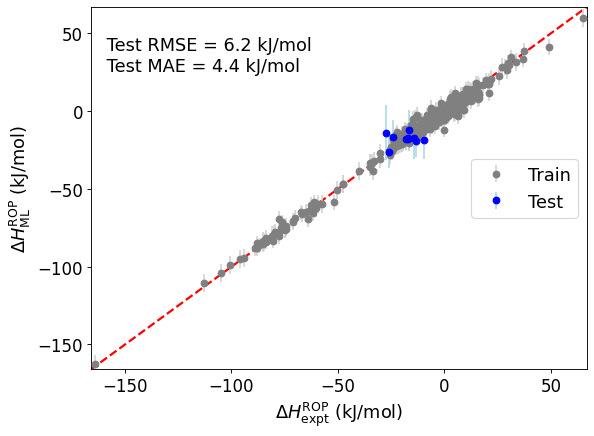

In [20]:
ax = parity_plot(y_train, train_predictions, train_sigmas, y_test, test_predictions, test_sigmas)
plt.savefig('final_production_model_parity_plot.pdf')

In [36]:
# parity plotting
def make_parity_plot(y_test_actual, y_test_prediction, sigmas_test, y_train_actual, y_train_prediction, sigmas_train):
    fig = plt.figure(figsize = (8,8))
    ## PLOT FORMATTING
    # find the boundaries of x and y values
    min_x = np.array([y_test_actual.min(), y_train_actual.min()]).min()
    max_x = np.array([y_test_actual.max(), y_train_actual.max()]).max()
    min_y = np.array([y_test_prediction.min(), y_train_prediction.min()]).min()
    max_y = np.array([y_test_prediction.max(), y_train_prediction.max()]).max()
    bounds = (min(min_x - 2, min_y  - 2), max(max_x + 2, max_y + 2))

    ax = plt.gca()
    ax.set_xlim(bounds)
    ax.set_ylim(bounds)
    
    # ax.set_aspect("equal", adjustable = "box")
    plots_ = list()
    # plot_train = plt.scatter(y_train_actual, y_train_prediction,s=50,c="#ff0018",edgecolor="#9b000e",marker="o",label='Train Data',zorder=4,)
    plot_train = plt.errorbar(y_train_actual, y_train_prediction, yerr=sigmas_train, c='grey', label='Train Data', zorder=4, ecolor='lightgrey', fmt='o')
    plots_.append(plot_train)
    
    # plot_test = plt.scatter(y_test_actual,y_test_prediction,s=50,c="#0d78b3",edgecolor="k",marker="s",label='Test Data',zorder=5,)
    plot_test = plt.errorbar(y_test_actual, y_test_prediction, yerr=sigmas_test, c='blue', label='Validation Data With DFT', zorder=4, ecolor='blue', fmt='o')
    plots_.append(plot_test)
    
    ax.plot([0,1], [0,1], "k--", lw = 2, transform = ax.transAxes)
    
    # labeling axes
    plt.xlabel('Actual Enthalpy (KJ/mol)')
    plt.ylabel('Predicted Enthalpy (KJ/mol)')
    
    ## CALCULATE STATISTICS
    # mean_abs_err_test = mean_absolute_error(y_test_actual, y_test_prediction)
    rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_prediction))
    r2_test = r2_score(y_test_actual, y_test_prediction)
    # mean_abs_err_train = mean_absolute_error(y_train_actual, y_train_prediction)
    rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_prediction))
    r2_train = r2_score(y_train_actual, y_train_prediction)
    # text = f"Test Data\n$\: \: MAE = {mean_abs_err_test:0.3f}$ \n $\: \: RMSE = {rmse_test:0.3f}$ \n $\: \: R^2 = {r2_test:0.3f}$\n Train Data\n $\: \: MAE =  {mean_abs_err_train:0.3f}$ \n     $\: \: RMSE = {rmse_train:0.3f}$ \n $\: \: R^2 = {r2_train:0.3f}$"
    text = f"Test Data (blue)\n$\: \: RMSE = {rmse_test:0.3f}$ kJ/mol \n $\: \: R^2 = {r2_test:0.3f}$\n Train Data (Grey)\n $\: \: RMSE = {rmse_train:0.3f}$ kJ/mol \n $\: \: R^2 = {r2_train:0.3f}$"
    plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes, fontsize=15, verticalalignment='top')
    return fig

/var/folders/kv/jb_0lzrs1rn1t7k838wy_wgc0000gn/T/ipykernel_16417/834855245.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/kv/jb_0lzrs1rn1t7k838wy_wgc0000gn/T/ipykernel_16417/834855245.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/kv/jb_0lzrs1rn1t7k838wy_wgc0000gn/T/ipykernel_16417/834855245.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/kv/jb_0lzrs1rn1t7k838wy_wgc0000gn/T/ipykernel_16417/834855245.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/kv/jb_0lzrs1rn1t7k838wy_wgc0000gn/T/ipykern

[[ 1.57117992  9.17036926]
 [ 1.45184904  7.7888394 ]
 [ 1.61781178 17.92790091]
 [ 1.40999973  5.25004085]
 [ 1.54664354  9.06273966]
 [ 1.57204874  5.96648382]
 [ 1.5884091   7.39812819]
 [ 1.5876556   8.37079879]
 [ 1.50749987  9.40753864]
 [ 1.60742632  7.63381225]]
-------------
[[ 0.99475947  0.89621008]
 [ 0.99569927  0.91284004]
 [ 0.99463665  0.54566178]
 [ 0.99639679  0.50388428]
 [ 0.99556532  0.33588659]
 [ 0.99560843 -0.0264511 ]
 [ 0.99551994 -1.37791788]
 [ 0.99451913  0.91583479]
 [ 0.99511026  0.89537629]
 [ 0.99495825  0.88245062]]
-------------
train rmse:  1.5460523640568424 test rmse:  8.797665178502907
train r2:  0.9952773502568452 test r2:  0.44837754907131877


/var/folders/kv/jb_0lzrs1rn1t7k838wy_wgc0000gn/T/ipykernel_16417/834855245.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


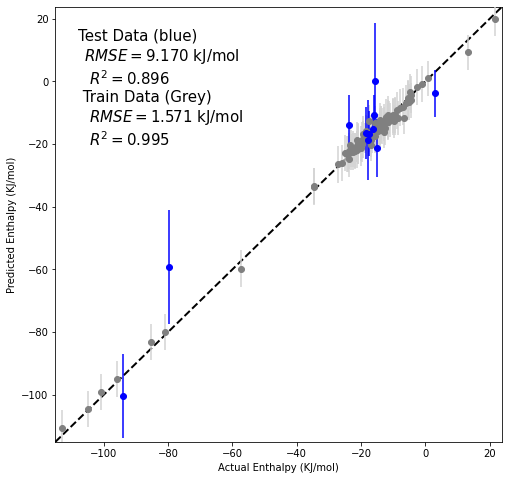

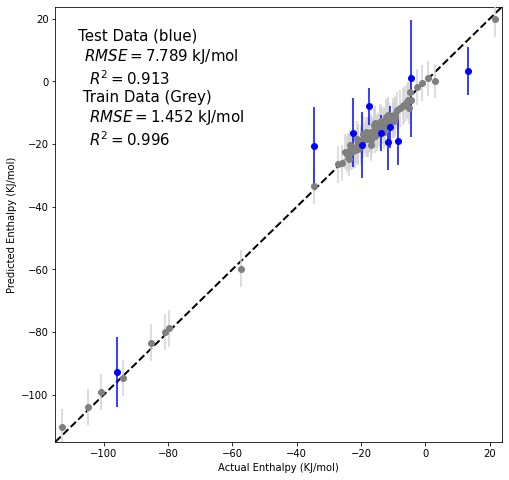

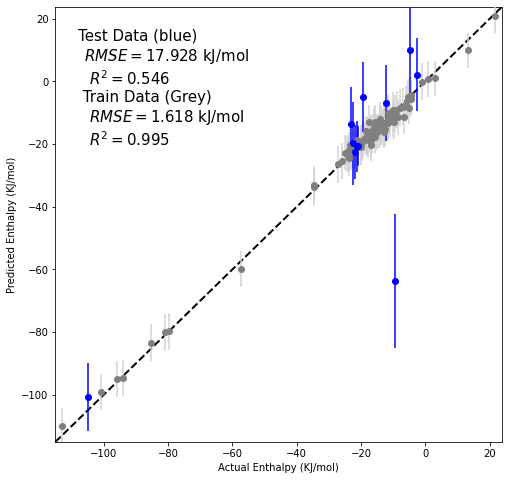

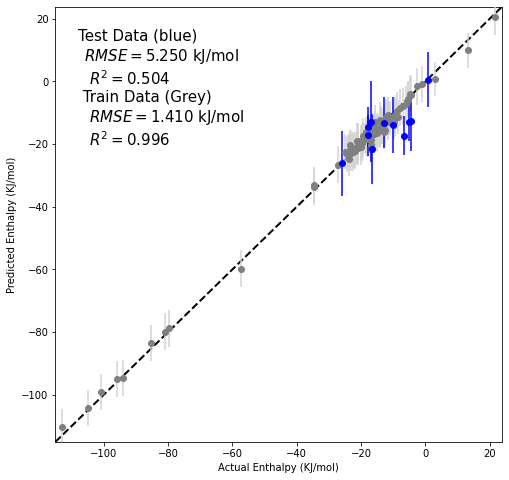

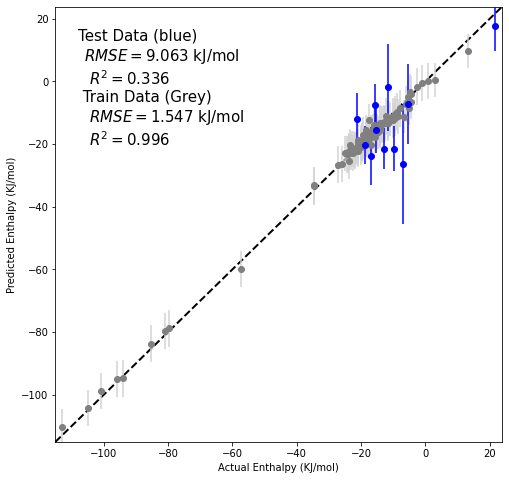

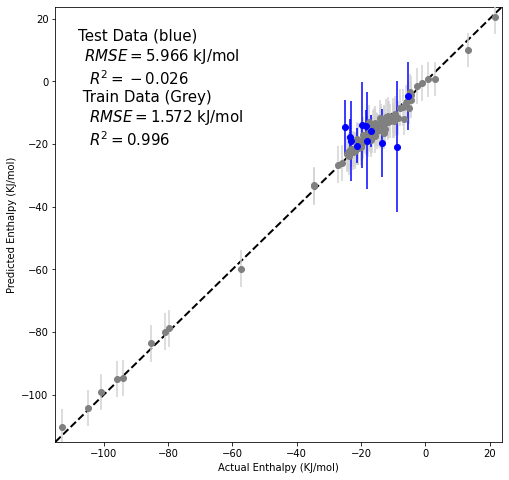

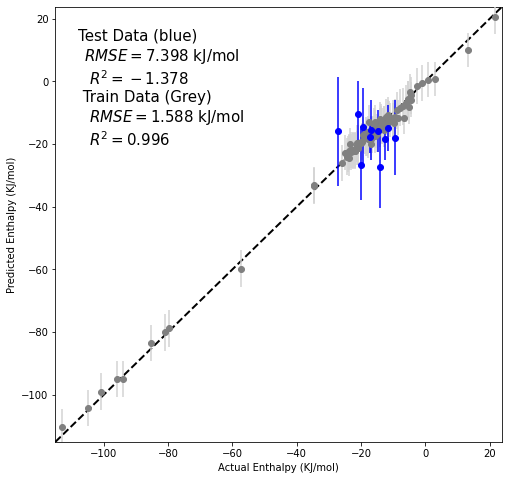

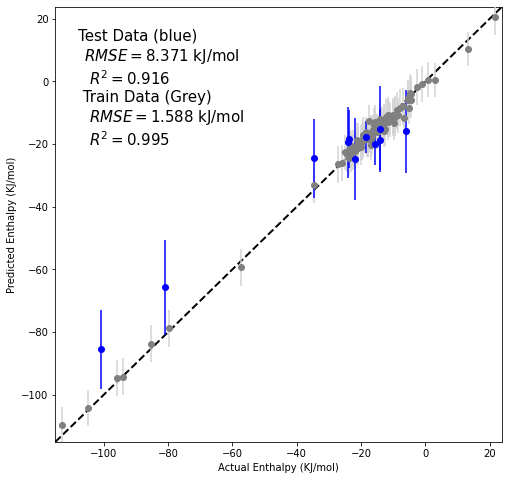

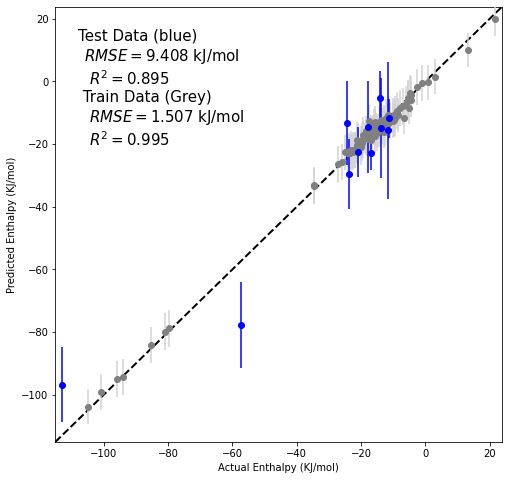

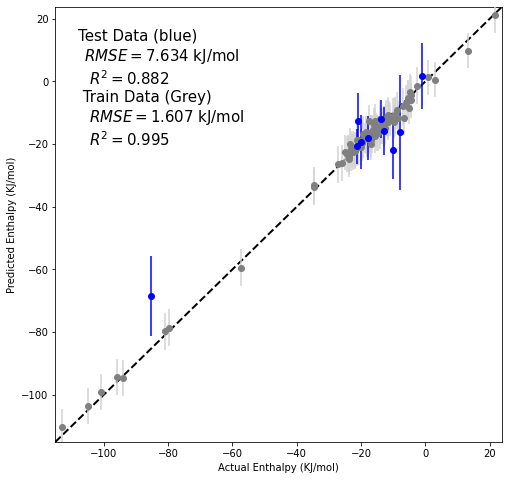

In [58]:
# five fold cross validation to get final metrics
# CV testing to see if all folds have as bad of overfitting
fp_columns.append('ID')
x_exp = df[df['source']=='expt'][fp_columns].to_numpy()
y_exp = df[df['source']=='expt']['roe_kj/mol'].to_numpy()
fp_columns.pop()
x_to_add = df[df['source']=='dft'][fp_columns].to_numpy()
y_to_add = df[df['source']=='dft']['roe_kj/mol'].to_numpy()
kf = KFold(n_splits=10, shuffle=True)
rmses = []
r2s = []
split_test_ids = []
individual_predictions = {0: pd.DataFrame(), 1: pd.DataFrame(), 2: pd.DataFrame(), 3: pd.DataFrame(), 4: pd.DataFrame(),}

count=0
for train_index, test_index in kf.split(x_exp):
    x_train, x_test = x_exp[train_index], x_exp[test_index]
    # removing ID from x values
    x_train = x_train[:,:-1]
    test_ids = list(x_test[:,-1].flatten())
    split_test_ids.append(test_ids)
    x_test = x_test[:,:-1]
    y_train, y_test = y_exp[train_index], y_exp[test_index]
    
    x_train = np.concatenate([x_train, x_to_add],axis=0)
    y_train = np.concatenate([y_train, y_to_add],axis=0)
    model = GaussianProcessRegressor(**params)
    model.fit(x_train, y_train)
    
    train_predictions, train_sigmas = model.predict(x_exp[train_index][:,:-1], return_std=True)
    # train_predictions_for_plot, train_sigmas_for_plot = model.predict(x_train, return_std=True)
    test_predictions, test_sigmas = model.predict(x_test, return_std=True)
    
    rmse_train = np.sqrt(mean_squared_error(y_exp[train_index], train_predictions))
    r2_train = r2_score(y_exp[train_index], train_predictions)
    rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
    r2_test = r2_score(y_test, test_predictions)
    
    rmses.append([rmse_train, rmse_test])
    r2s.append([r2_train, r2_test])
#     individual_predictions[count]['ID'] = test_ids
#     individual_predictions[count]['actual_enthalpy'] = y_test
#     individual_predictions[count]['error'] = abs(y_test-test_predictions)
    
    # making parity plot to visualize test/train splits that lead to poor results
    fig = make_parity_plot(y_test, test_predictions, test_sigmas, y_exp[train_index], train_predictions, train_sigmas)
    # print(test_ids)
    fig.show()
    count+=1
    
rmses = np.array(rmses)
r2s = np.array(r2s)
print(rmses)
print('-------------')
print(r2s)
print('-------------')
print('train rmse: ', np.mean(rmses[:,0]), 'test rmse: ', np.mean(rmses[:,1]))
print('train r2: ', np.mean(r2s[:,0]), 'test r2: ', np.mean(r2s[:,1]))

In [21]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.1.


In [29]:
# need to save model, feature names/order, and metadata to put into API code
with open('23-8-26_enthalpy_production_model.pkl', "wb") as f:
    joblib.dump(model, f)

with open('enthalpy_fp_headers.json', "w") as f:
    json.dump(fp_columns, f)

metadata = {
    "model": "Gaussian Process Regression", 
    "polymer_fingerprint_scheme": "pgfingerprinting", 
    "polymer_fingerprint_parameters": {
        "fp_identifier": "fp_",
        'col_smiles': 'smiles_polymer',
        'col_X': ['aT', 'bT', 'm', 'e'],
        'col_id': 'ID',
        'polymer_fp_version': 2,
        'drop_failed_rows': 1,
        'file_fingerprint': 'fp_polymer.csv',
        'write_Y': 2,
        'verbosity': 1
    },
    "monomer_fingerprint_scheme": "pgfingerprinting", 
    "polymer_fingerprint_parameters": {
        "fp_identifier": "fp_",
        'col_smiles': 'smiles_monomer',
        'col_X': ['aS', 'm', 'e'],
        'col_id': 'ID',
        'polymer_fp_version': 2,
        'drop_failed_rows': 1,
        'ismolecule': 1,
        'file_fingerprint': 'fp_monomer.csv',
        'write_Y': 2,
        'verbosity': 1
    },
    "model_import": "from sklearn.ensemble import RandomForestClassifier",
    "scikit_learn_version": "1.0.1",
    "pgfingerprinting_version": {
        "type": "git",
        "url": "ssh://git@github.com/Ramprasad-Group/pgfingerprinting.git",
        "reference": "main",
        "resolved_reference": "3701581a055670621dc944816d34aa53a5711eea"
    }
}

with open("metadata.json", "w") as f:
    json.dump(metadata, f)

In [30]:
# also going to save dataframes that have data to predict and the predictions given by the model here to make sure 
# my model is predicting consistently
# also will have fingerprints so I can make sure that my fingerprinting scheme is working as it needs to
test_df['local_predictions_kJ/mol'] = test_predictions
test_df['local_sigmas_kJ/mol'] = test_sigmas
test_df.to_csv('enthalpy_testing_data_df.csv')

/var/folders/kv/jb_0lzrs1rn1t7k838wy_wgc0000gn/T/ipykernel_16417/983880088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['local_predictions_kJ/mol'] = test_predictions
/var/folders/kv/jb_0lzrs1rn1t7k838wy_wgc0000gn/T/ipykernel_16417/983880088.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['local_sigmas_kJ/mol'] = test_sigmas


In [31]:
print(test_df)

     Unnamed: 0  1/length      ID  roe_kj/mol  \
1             1       0.0     4.0       -16.8   
5             5       0.0    12.0       -17.1   
10           10       0.0    21.0       -18.0   
22           22       0.0   949.0        -9.5   
26           26       0.0   983.0       -26.0   
27           27       0.0   986.0       -24.0   
51           60       0.0  1045.0       -14.1   
58           68       0.0  1054.0       -17.0   
92          106       0.0  1131.0       -27.3   
102         116       0.0  1141.0       -13.4   

                      smiles_monomer                        smiles_polymer  \
1              CC1CCC(C(C)C)OC(=O)C1           [*]OC(CCC(C)CC([*])=O)C(C)C   
5                  CCCCCC1CCCC(=O)O1               [*]OC(CCCCC)CCCC([*])=O   
10                   O=C2CC1CCCCC1O2                 [*]OC1CCCCC1CC([*])=O   
22                        O=C1CSCCS1                      [*]SCCSCC([*])=O   
26                        O=C1OCCCO1                      [*]OCCCOC([*